# Lecture 12 - Reservoir Computers and Echo State Networks

## Contents
1. [Recurrent Neural Networks](#rnn)
2. [Reservoir Computers and Echo State Networks](#esn)
3. [Cross-Validation](#cv)
4. [ReservoirComputing.jl](#rcjl)
5. [Further Reading](#further-reading)

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add(["DynamicalSystems", "ReservoirComputing", "Plots", "Printf", "MKL"])

  Activating project at `~/code/TUM-Dynamics-Lecture/lectures/lecture-12`
   Resolving package versions...
  No Changes to `~/code/TUM-Dynamics-Lecture/lectures/lecture-12/Project.toml`
  No Changes to `~/code/TUM-Dynamics-Lecture/lectures/lecture-12/Manifest.toml`


In [2]:
using DynamicalSystems, ReservoirComputing, Plots, Printf, MKL

## 1. Recurrent Neural Networks <a class="anchor" id="rnn"></a>

### 1.1. Overview

- Recurrent neural networks (RNNs) are a family of neural networks for processing **sequential data**.
<br>

- Consider a sequence of the form

$$\mathbf s^{(t)} = f(\mathbf s^{(t-1)}; \mathbf \theta),$$

where $\mathbf s^{(t)}$ is a vector describing the value of the sequence at the discrete index $t$, and $\mathbf \theta$ are some parameters of the function $f$.


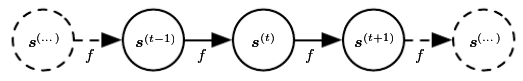
[Image source](https://www.deeplearningbook.org/)

- We call such a sequence **recurrent** because the definition of $\mathbf s$ at time $t$ refers back to the same definition at time $t-1$.
<br>

- We can immediately see the correspondence here with a discrete autonomous dynamical system, with the vector $\mathbf s^{(t)}$ describing the state of the system at time $t$ and the function $f$ defining the equations of motion.
<br>

- More generally, we can also consider a dynamical system driven by an external signal $\mathbf x^{(t)}$,

$$\mathbf s^{(t)} = f(\mathbf s^{(t-1)}, \mathbf x^{(t)}; \mathbf \theta),$$

in which case the state $\mathbf s^{(t)}$ now contains information about the entire past sequence $(\mathbf x^{(t)}, \mathbf x^{(t-1)}, \ldots, \mathbf x^{(2)}, \mathbf x^{(1)})$. In other words, **memory** of previous inputs $(\mathbf x^{(t)}, \mathbf x^{(t-1)}, \ldots, \mathbf x^{(2)}, \mathbf x^{(1)})$ is persisted in the state $\mathbf s^{(t)}$ of the system.
<br>

- In the context of RNNs, the state $\mathbf s^{(t)}$ which is being propagated forwards in time is usually the **activations of the hidden units of the network**. To make this explicit, we introduce the variable $\mathbf h^{(t)}$ to represent the hidden state of the network at time $t$, such that

$$\mathbf h^{(t)} = f(\mathbf h^{(t-1)}, \mathbf x^{(t)}; \mathbf \theta),$$

and this will be the **general form of an RNN** that we will consider. 
<br>

- In other words, **an RNN is a neural network whose hidden state at time $t$ is a function of its hidden state at the previous timestep $t-1$ and an input signal at time $t$**.

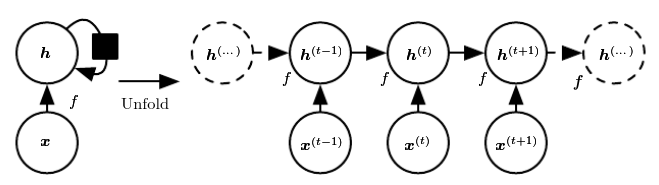
[Image source](https://www.deeplearningbook.org/)
    
- An RNN can develop self-sustained dynamics due to its recurrent connections, even in the absence of input, by simply connecting its output back to its input. Indeed, it can be shown that, under fairly mild and general assumptions, that RNNs are **universal approximators of dynamical systems**.
<br>

- For a finite number of steps, we can "unfold" the computational graph by repeatedly applying the definition of $\mathbf h^{(t)}$:

$$
\begin{aligned}
\mathbf h^{(t)} &= f(\mathbf h^{(t-1)}, \mathbf x^{(t)}; \mathbf \theta),\\
                &= f(f(\mathbf h^{(t-2)}, \mathbf x^{(t-1)}; \mathbf \theta), \mathbf x^{(t)}; \mathbf \theta),\\
                &\;\vdots \\
                &= g^{(t)}(\mathbf x^{(t)}, \mathbf x^{(t-1)}, \ldots, \mathbf x^{(2)}, \mathbf x^{(1)}),
\end{aligned}
$$

where the function $g^{(t)}$ takes the entire past sequence $(\mathbf x^{(t)}, \mathbf x^{(t-1)}, \ldots, \mathbf x^{(2)}, \mathbf x^{(1)})$ as input and returns the current state.


- If we wanted to predict the state of the system $\mathbf h^{(t)}$ given the history of the input sequence $(\mathbf x^{(t)}, \mathbf x^{(t-1)}, \ldots, \mathbf x^{(2)}, \mathbf x^{(1)})$, we could train an MLP to approximate the function $g^{(t)}$.
<br>

- However, the recurrent formulation of the problem, based on repeated applications of the function $f$, has two major advantages compared to a single application of the function $g^{(t)}$:

    1. Regardless of the sequence length, the learned model always has the **same input size**, because it is speciﬁed in terms of the transition from one state to another state, rather than speciﬁed in terms of a variable-length history of states.
    2. It is possible to use the same transition function $f$ with the same parameters at every time step. This is an example of **parameter sharing**.<br><br>
   
    

- It is thus possible to learn a single model $f$ that operates on all time steps and all sequence lengths, rather than needing to learn a separate model $g^{(t)}$ for all possible time steps. 
<br>

- Learning a single shared model allows generalization to sequence lengths that did not appear in the training set, and enables the model to be estimated with far fewer training examples than would be required without parameter sharing.
<br>

- When a recurrent network is trained to perform a task that requires predicting the future from the past, the network typically learns to use $\mathbf h^{(t)}$ as a kind of lossy summary of the task-relevant aspects of the past sequence $(\mathbf x^{(t)}, \mathbf x^{(t-1)}, \ldots, \mathbf x^{(2)}, \mathbf x^{(1)})$.


### 1.2. Two Example RNN Architectures


- Given the general form of a RNN,

$$\mathbf h^{(t)} = f(\mathbf h^{(t-1)}, \mathbf x^{(t)}; \mathbf \theta),$$

many RNN architectures are possible, depending on the specific task at hand. Below are two examples.


#### 1. Sequence-to-Sequence Mapping

- This network reads in a sequence $\mathbf x$ and outputs a sequence $\mathbf o$ of the same length.

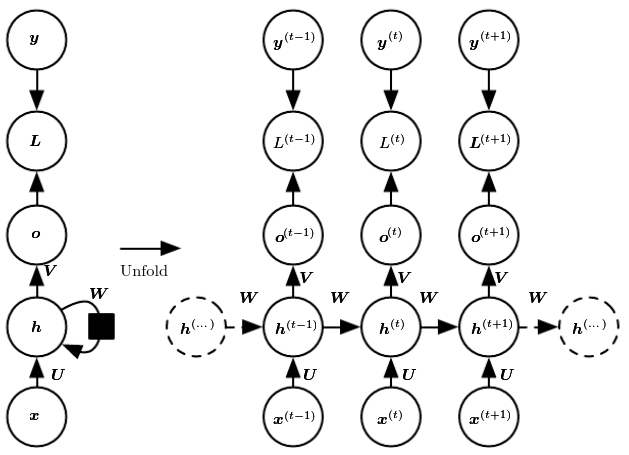
[Image source](https://www.deeplearningbook.org/)

- The output $\mathbf o^{(t)}$ of the RNN at time $t$ is read from the hidden state via some (learnable) parameters $\mathbf V$ and compared to a ground truth $\mathbf y^{(t)}$ via some loss function $L$.
<br>

- The update equations for this network are

$$
\begin{aligned}
\mathbf h^{(t)} &= f(\mathbf b + \mathbf W \mathbf h^{(t-1)} + \mathbf U \mathbf x^{(t)}),\\
\mathbf o^{(t)} &= g(\mathbf c + \mathbf V \mathbf h^{(t)}),\\
\end{aligned}
$$

where $f$ and $g$ (not shown on the graph) are the activation funtions for the hidden-to-hidden and hidden-to-output connections, respectively. $f$ will typically be some nonlinear activation function, such as $\tanh$, while $g$ will be chosen depending on the exact nature of the problem, and may be the identity function if the hidden layer is to be read out directly. 
<br>

- The learnable parameters of this network are the bias vectors $\mathbf b$ and $\mathbf c$ as well as the weight matrices $\mathbf U$, $\mathbf V$ and $\mathbf W$, for input-to-hidden, hidden-to-output and hidden-to-hidden connections, respectively.
<br>

- As an example, this kind of architecture could be used for part-of-speech (POS) tagging, where we want to label each word in a sentence with its grammatical part of speech (noun, verb, adjective, and so on). In this case, $h(t)$ would maintain contextual information about the sentence structure, which is important because the same word can have different POS tags depending on context.


#### 2. Sequence-to-Vector Mapping

- This network reads in a sequence $\mathbf x$ and outputs a vector $\mathbf o$.

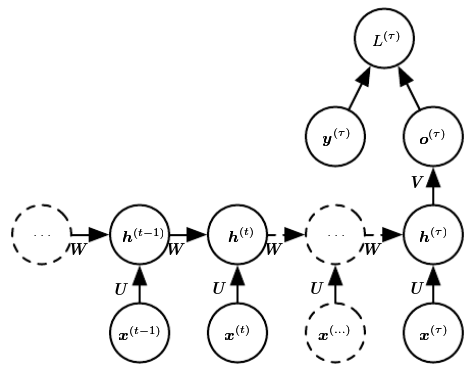
[Image source](https://www.deeplearningbook.org/)

- A network like this could be used to summarise a sequence in terms of a fixed-size vector. This is particularly useful in classification tasks, such as sentiment analysis or email spam filters.

### 1.3. Training RNNs Is Hard

- Gradients of an RNN can be computed by applying backpropagation to the unrolled computational graph of the network.
<br>

- This procedure is known as **backpropagation through time** (BPTT) and its runtime is $O(\tau)$, where $\tau$ is the length of the input sequence.
<br>

- However, RNNs are in general difficult to train by gradient-based methods:
    1. The RNN dynamics may undergo **bifurcations** as the parameters are varied during training, at which point the gradient may become ill-defined.
    2. Backpropagation through time is **expensive**.
    3. Learning **long-term dependencies** with gradient-based methods is inherently difficult.<br><br>
    
- To understand the difficulties inherent in taking gradients of RNNs, consider the recurrence relation,

$$\mathbf h^{(t)} = \mathbf W^{\mathrm T}\mathbf h^{(t-1)},$$

which could be a very simple RNN with no inputs and no activation function.


- The state $\mathbf h^{(t)}$ is obtained by repeated application of the matrix $\mathbf W$:

$$\mathbf h^{(t)} = (\mathbf W^{\mathrm T})^t\mathbf h^{(0)}.$$


- If $\mathbf W$ admits an eigendecomposition of the form $\mathbf W = \mathbf Q \mathbf{\Lambda} \mathbf Q^{\mathrm T}$, with $\mathbf Q$ orthogonal and $\mathbf{\Lambda} = \mathrm{diag}(\boldsymbol \lambda)$, where $\boldsymbol \lambda$ are the eigenvalues of $\mathbf W$, then

$$\mathbf h^{(t)} = \mathbf Q^{\mathrm T} \mathbf{\Lambda}^t \mathbf Q\mathbf h^{(0)}.$$


- The eigenvalues are raised to the power of $t$, causing eigenvalues with magnitude less than one to decay to zero and eigenvalues with magnitude greater than one to explode. As a result, any component of $\mathbf h^{(0)}$ that is not aligned with the largest eigenvector will eventually be discarded.
<br>

- Even worse, **gradients** through a computational graph of this form are also scaled according to $\mathbf{\Lambda}^t$, meaning that they will tend to either decay or explode for moderately large $t$. This is known as the **vanishing and exploding gradient problem**. 
<br>

- Vanishing gradients make it diﬃcult to know in which direction the parameters should move to improve the cost function, while exploding gradients can make learning unstable.
<br>

- A number of strategies exist to deal with vanishing and exploding gradients in RNNs. Two well-known examples are Long Short-Term Memory (LSTM) networks and Gated Recurrent Units (GRU). In this lecture, however, we will focus on an architecture which has been demonstrated to be particularly (even astonishingly) effective for learning the dynamics of chaotic systems: reservoir computers.

## 2. Reservoir Computers and Echo State Networks <a class="anchor" id="esn"></a>

### 2.1. Overview

- Motivated by the difficulties associated with training RNNs via gradient-based methods, in 2001 a new class of RNN was proposed independently by Wolfgang Maas, under the name **Liquid State Machines** (LSMs), and Herbert Jaeger, under the name **Echo State Networks** (ESNs). 
<br>

- Together, these approaches to RNN design are collectively known as **reservoir computing** (RC). We will focus on ESNs.
<br>

- A typical ESN looks like

![Reservoir](assets/reservoir.png)
[Edited from original figure from Source](https://link.springer.com/chapter/10.1007/978-3-642-35289-8_36)

where $n$ is the discrete time index, $\mathbf x(n) \in \mathbb{R}^{N_x}$ is the input signal, $\mathbf r(n) \in \mathbb{R}^{N_r}$ are the reservoir activations, $\mathbf W^{\mathrm{in}} \in \mathbb{R}^{N_r \times N_x}$ are the input-to-reservoir weights, $\mathbf W \in \mathbb{R}^{N_r \times N_r}$ are the reservoir-to-reservoir weights, $\mathbf W^{\mathrm{out}} \in \mathbb{R}^{N_y \times N_r}$ are the reservoir-to-output weights, and $\mathbf y(n) \in \mathbb{R}^{N_y}$ is the network output.


- As the input sequence $\mathbf x(n)$ is fed into the ESN, the reservoir state $\mathbf r(n)$ and the output $\mathbf y(n)$ are updated according to the update equations

$$\begin{aligned}
\mathbf{\tilde r} (n) &= g\left (\mathbf W^{\mathrm{in}}\mathbf x (n) + \mathbf W \mathbf r (n-1)\right ), \\
\mathbf r(n) &= (1-\alpha)\mathbf r(n-1) + \alpha \mathbf{\tilde r}(n),\\
\mathbf y(n) &= \mathbf{W}^{\mathrm{out}}\mathbf r(n) = \mathbf{x}(n+1),
\end{aligned}
$$

where $g$ is a sigmoidal activation function applied element-wise and $\alpha \in (0,1]$ is the leaking rate. We can think of the leaking rate $\alpha$ as controlling the "speed" of the update dynamics. In most studies on dynamical systems $\alpha = 1$.
<br>

- As we can see, the reservoir activations at a given time $n$ are a function of the reservoir activations at the previous time $n-1$ and the input signal at time $n$. That is, this architecture satisfies our earlier definition of a recurrent neural network.
<br>

- For simplicity, we will restrict our attention to the case where $\alpha = 1$, i.e. without leaky integration, and we will use a $\tanh$ activation function, which is a common default. The update equations for this simplified configuration are

$$\begin{aligned}
\mathbf{r} (n) &= \tanh\left (\mathbf W^{\mathrm{in}}\mathbf x (n) + \mathbf W \mathbf r (n-1)\right ), \\
\mathbf y(n) &= \mathbf{W}^{\mathrm{out}}\mathbf r(n).
\end{aligned}
$$


- **The essential feature of a reservoir computer is that $\mathbf W$ and $\mathbf W^{\mathrm{in}}$, which define the reservoir dynamics, are generated randomly and do not change**. 
<br>

- That is, the weight matrices $\mathbf W$ and $\mathbf W^{\mathrm{in}}$ are fixed and not directly optimised during training.
<br>

- The output of the network $\mathbf y(n)$ is a linear combination of the reservoir activations $\mathbf r(n)$, meaning we can solve directly for the output weights $\mathbf W^{\mathrm{out}}$ via linear regression, minimising the MSE between the model prediction $\mathbf y(n) = \mathbf W^{\mathrm{out}} \mathbf r(n)$ and the training target $\mathbf y^{\mathrm{target}}(n)$.
<br>

- As a result of this procedure, **we avoid completely the need to take gradients through the network**, thus sidestepping the challenges associated with taking gradients through RNNs which we discussed earlier.

### 2.2. The Echo State Property

- It is important that an ESN possesses the *echo state property*, meaning that the effect of a previous state $\mathbf r(n)$ and a previous input $\mathbf x(n)$ on a future state $\mathbf r(n+k)$ should vanish, i.e. it should neither persist nor get amplified, as time passes ($k \to \infty$).
<br>

- For most practical purposes, the echo state property is assured if the reservoir weight matrix $\mathbf W$ is scaled so that its spectral radius $\rho (\mathbf W)$ (i.e., its largest absolute eigenvalue) satisfies $\rho (\mathbf W) < 1$.
<br>

- In certain cases, the echo state property may also be satisfied even with $\rho (\mathbf W) > 1$, while it may also not be satisifed even with $\rho (\mathbf W) < 1$.
<br>

- The optimal value of $\rho (\mathbf W)$ should be set depending on the amount of memory and nonlinearity required by the task at hand.
<br>

- As a rule of thumb, $\rho (\mathbf W)$ should be close to 1 for tasks that require long memory, and smaller otherwise.

### 2.3. Training ESNs is Easy: A Practical Guide to ESN Hyperparameters

- As we discussed earlier, the basic method for training an ESN consists of:

    1. Generate a large random reservoir, defined by $\mathbf W^{\mathrm{in}}$ and $\mathbf W$.  
    2. Run it using the training input $\mathbf x(n)$ and collect the corresponding reservoir activations $\mathbf r(n)$
    3. Compute the linear readout weights $\mathbf W^{\mathrm{out}}$ using linear regression, minimising the MSE between $\mathbf y(n) = \mathbf W^{\mathrm{out}}\mathbf r(n)$ and $\mathbf y^{\mathrm{target}}(n)$.<br><br>

- While the reservoir is fixed once it has been generated, a number of important hyperparameters control the process used to generate $\mathbf W^{\mathrm{in}}$ and $\mathbf W$.
<br>

- In essence, **optimisation of ESNs consists of choosing optimal hyperparameters rather than network weights**.
    
#### 2.3.1 Reservoir Size

- The reservoir acts as both a nonlinear expansion and a memory of the input $\mathbf x(n)$.
<br>

- The goal is that the reservoir should constitute a sufficiently rich and relevant signal space in $\mathbf r(n)$ that the desired $\mathbf y^{\mathrm{target}}(n)$ can be obtained as a linear combination from it.
<br>

- The bigger the space of reservoir signals $\mathbf r(n)$, the easier it is to find a linear combination of the signals to approximate $\mathbf y^{\mathrm{target}}(n)$.
<br>

- In general, the bigger the reservoir, the better the performance, *provided appropriate regularisation measures are taken against overfitting*.

#### 2.3.2. Reservoir Sparsity

- Sparse reservoir connections, i.e. setting most of the elements of $\mathbf W$ equal to zero, can have a small but positive effect on performance.
<br>

- However, sparse matrix representations can have a significant effect on the cost of reservoir updates, significantly speeding up the model, assuming the underlying model implementation takes advantage of the sparsity.
<br>

- It is recommend to connect each reservoir node to a small fixed number of other nodes (e.g. 10) on average, regardless of the reservoir size.


#### 2.3.3. Spectral Radius of the Reservoir

- The nonzero elements of the reservoir connection matrix $\mathbf W$ are typically drawn from a symmetric uniform distribution.
<br>

- One of the most important hyperparameters of an ESN is the spectral radius $\rho (\mathbf W)$, i.e the maximum absolute eigenvalue of $\mathbf W$.
<br>

- Generally, a random sparse $\mathbf W$ is generated, its spectral radius $\rho (\mathbf W)$ is computed, then $\mathbf W$ is divided by $\rho (\mathbf W)$ to obtain a matrix with unit spectral radius.
<br>

- This $\mathbf W$ with unit spectral radius should be considered an initial starting point for training, with the final value of $\rho (\mathbf W)$ chosen to optimise performance.
<br>

- In general, $\rho (\mathbf W)$ should be greater for tasks where a more extensive history of the input is required to perform it, and smaller for tasks where the current output $\mathbf y(n)$ depends more on the recent history of $\mathbf x(n)$. 

#### 2.3.4. Input Scaling

- $\mathbf W_{\mathrm{in}}$ is typically dense rather than sparse, with its elements also drawn from a symmetric uniform distribution.
<br>

- We define the input scaling $a$ as the range of the interval $[-a, a]$ from which the values of $\mathbf W_{\mathrm{in}}$ are sampled.
<br>

- To keep the number of model hyperparameters to a minimum, often all the columns of $\mathbf W_{\mathrm{in}}$ are scaled with the same parameter $a$. However, if the individual components of $\mathbf x(n)$ contribute to the task in very different ways, each column of $\mathbf W_{\mathrm{in}}$ may be scaled differently.

### 2.4. ESNs for Prediction of Dynamical Systems

- We will consider the prediction paradigm where we are given a timeseries corresponding to some dynamical system and we wish to predict the future trajectory of that system.
<br>

- We will thus use an ESN in two configurations:
    1. In the **training phase**, the input to the ESN is set to the previous value of the timeseries, that is, $\mathbf x(n) = \mathbf y^{\mathrm{target}}(n-1)$. In essence, we are training the ESN to predict the next value of the timeseries, given the trajectory up to that point.
    2. In the **prediction phase**, we switch the input to the previous prediction of the ESN, that is, $\mathbf x(n) = \mathbf y(n-1)$. In this configuration, the ESN can be run autonomously to generate timeseries of arbitrary duration.
    

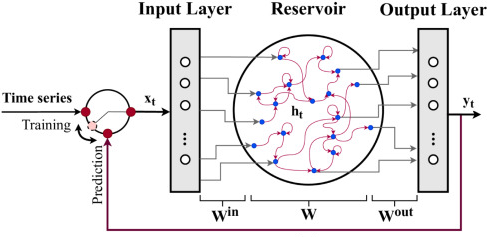
[Image source](https://doi.org/10.1016/j.mlwa.2022.100300)

## 3. Recap: Hyperparameters and Cross-Validation <a class="anchor" id="cv"></a>
- Most machine learning algorithms have **hyperparameters**, which we can think of as settings controlling the algorithm's behaviour.
<br>

- Common hyperparameters in neural networks include the learning rate, the depth and width of the network, the choice of activation function, and the type and amount of regularisation.
<br>

- We call these settings hyperparameters to distinguish them from the model parameters which are directly adapted by the learning algorithm itself (say, neural network weights which are adapted by a gradient descent algorithm).
<br>

- In general, **it is not appropriate to optimise a hyperparameter on the training set**. For example, consider hyperparameters which control model capacity; we can always obtain a better fit to the training data by simply increasing the model capacity, but this is likely to result in overfitting and consequently poor generalisation to unseen data.
<br>

- Remember that we use an independent **test set** to estimate the generalisation error of a trained machine learning model. As always, it is essential that the test set is not used to make any decisions about the model, including its hyperparameters.
<br>

- To choose the optimal hyperparameters, we use a further independent **validation set** to estimate the generalisation error of an optimised machine learning model, *for a given set of hyperparameters*. The final choice of model will generally be the one with the lowest error on the validation set.
<br>

- To summarise, a rough outline of the procedure is:
    1. Split the data into training, validation, and test sets.
    2. For a given set of hyperparameters, train the model on the training set. Once training has completed, evaluate the model error on the validation set.
    3. Repeat step 2 for all relevant hyperparameter combinations.
    4. Select the model which has the lowest error *on the validation set*.
    5. For this model, evaluate the model error on the test set. This is our estimate of the model's generalisation error.

## 4. ReservoirComputing.jl <a class="anchor" id="rcjl"></a>

- [ReservoirComputing.jl](https://github.com/SciML/ReservoirComputing.jl) provides an implementation of reservoir computers in Julia.
<br>

- As an example, we will train an Echo State Network to reproduce the dynamics of the Lorenz system.

In [3]:
# Set up the Lorenz system from DynamicalSystems.jl
ds = Systems.lorenz63()

# Compute the maximum Lyapunov exponent of the system (we will use this to benchmark the model predictions later)
λ_max = lyapunov(ds, 100, Ttr = 100)

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0  # Transient that will be discarded

tr = trajectory(ds, T, Δt = Δt, Ttr = Ttr)
x, y, z = columns(tr[1])

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = copy(hcat(x, y, z)')

3×2001 Matrix{Float64}:
  -7.9554  -15.3466  -13.1091  -3.50536  …   2.60804   4.85809   9.20262
 -14.5316  -21.0154   -3.5192   3.71577      4.24185   7.98143  14.6799
  12.6248   30.0779   41.0784  30.7804      17.4522   15.3366   18.8447

In [4]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)
    N = size(data, 2)
    N_val = round(Int, val_seconds / Δt)
    N_test = round(Int, test_seconds / Δt)
    
    ind1 = N - N_test - N_val
    ind2 = N - N_test
    
    train_data = data[:, 1:ind1]
    val_data = data[:, ind1+1:ind2]
    test_data = data[:, ind2+1:end]
    
    return train_data, val_data, test_data
end

train_val_test_split

In [ ]:
# Generate and train an ESN
esn = ESN(
    u_train,
    3,
    reservoir_size;
    reservoir=rand_sparse(; radius=spectral_radius, sparsity=sparsity),
    input_layer=scaled_rand(; scaling=input_scale),
)

In [5]:
"""
    train_esn!(esn, y, ridge_param)

Given an Echo State Network, train it on the target sequence y_target and return the optimised output weights Wₒᵤₜ.
"""
function train_esn!(esn, y_target, ridge_param)
    training_method = StandardRidge(ridge_param)
    return train(esn, y_target, training_method)
end

train_esn!

In [11]:
"""
    cross_validate_esn(train_data, val_data, param_grid)

Do a grid search on the given param_grid to find the optimal hyperparameters.
"""
function cross_validate_esn(train_data, val_data, param_grid)
    best_loss = Inf
    best_params = nothing

    # We want to predict one step ahead, so the input signal is equal to the target signal from the previous step
    # i.e. the sequence is shifted by one step
    u_train = train_data[:, 1:end-1]
    y_train = train_data[:, 2:end]
        
    for hyperparams in param_grid        
        # Unpack the hyperparams struct
        (; reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = hyperparams

        # Generate and train an ESN
        esn = ESN(
            u_train,
            3,
            reservoir_size;
            reservoir=rand_sparse(; radius=spectral_radius, sparsity=sparsity),
            input_layer=scaled_rand(; scaling=input_scale),
        )
        Wₒᵤₜ = train_esn!(esn, y_train, ridge_param)

        # Evaluate the loss on the validation set
        steps_to_predict = size(val_data, 2)
        prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
        loss = sum(abs2, prediction - val_data)
        
        # Keep track of the best hyperparameter values
        if loss < best_loss
            best_loss = loss
            best_params = hyperparams
            println(best_params)
            @printf "Validation loss = %.1e\n" best_loss
        end
    end
    
    # Retrain the model using the optimal hyperparameters on both the training and validation data
    # This is necessary because we don't want errors incurred during validation to affect the test error
    (;reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = best_params
    data = hcat(train_data, val_data)
    u = data[:, 1:end-1]
    y = data[:, 2:end]
    esn = ESN(
        u,
        3,
        reservoir_size;
        reservoir=rand_sparse(; radius=spectral_radius, sparsity=sparsity),
        input_layer=scaled_rand(; scaling=input_scale),
    )
    Wₒᵤₜ = train_esn!(esn, y, ridge_param)
    
    return esn, Wₒᵤₜ
end

cross_validate_esn

In [12]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600))
end

plot_prediction

In [6]:
"""
Hyperparameters for an Echo State Network.
"""
struct ESNHyperparams
    reservoir_size
    spectral_radius
    sparsity
    input_scale
    ridge_param
end

# Set up the hyperparameter grid-search
param_grid = []

reservoir_sizes = [512, 1024]
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1]
ridge_values = [0.0, 1e-6, 1e-5]

# Take the Cartesian product of the possible values
for params in Iterators.product(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
    push!(param_grid, ESNHyperparams(params...))
end

println(length(param_grid), " hyperparameter combinations.")

36 hyperparameter combinations.


In [13]:
train_data, val_data, test_data = train_val_test_split(data, val_seconds = 15 * λ_max, test_seconds = 15 * λ_max);

In [14]:
@time esn, Wₒᵤₜ = cross_validate_esn(train_data, val_data, param_grid);

ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 2.0e+04
ESNHyperparams(1024, 0.8, 0.03, 0.1, 0.0)
Validation loss = 1.2e+04
ESNHyperparams(1024, 0.8, 0.05, 0.1, 0.0)
Validation loss = 9.3e+03
ESNHyperparams(1024, 0.8, 0.03, 0.1, 1.0e-6)
Validation loss = 1.0e+02
 34.262625 seconds (16.12 M allocations: 2.481 GiB, 1.00% gc time, 21.69% compilation time)


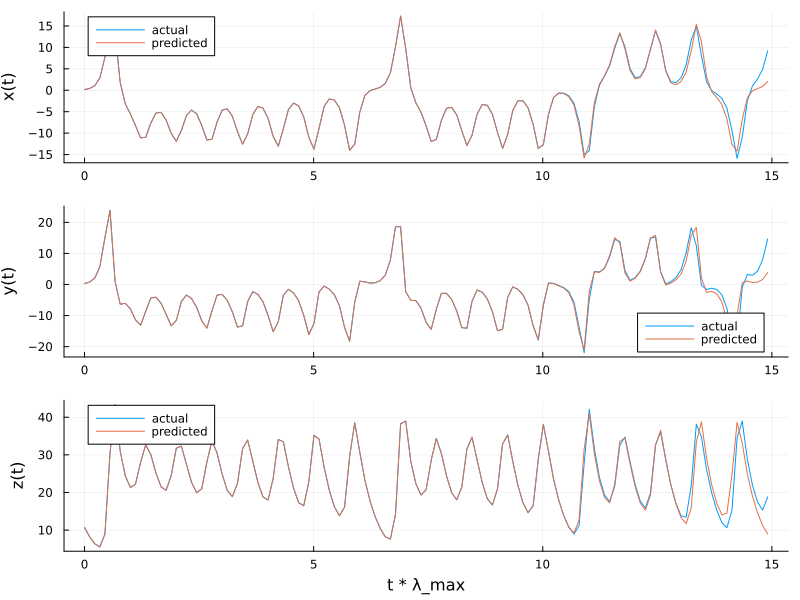

In [15]:
plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

## 5. Further Reading <a class="anchor" id="further-reading"></a>
1. Recurrent Neural Networks
    1. [Deep Learning (Goodfellow et al. 2016)](https://www.deeplearningbook.org/)
    2. [Probabilistic Machine Learning: An Introduction (Murphy 2022)](https://probml.github.io/pml-book/book1.html)
2. Reservoir Computers
    1. [Reservoir computing approaches to recurrent neural network training (Lukoševičius & Jaeger 2009)](https://doi.org/10.1016/j.cosrev.2009.03.005)
    2. [A Practical Guide to Applying Echo State Networks (Lukoševičius 2012)](https://doi.org/10.1007/978-3-642-35289-8_36)
    3. [Efficient Cross-Validation of Echo State Networks (Lukoševičius & Uselis 2019)](https://doi.org/10.1007/978-3-030-30493-5_12)
3. Reservoir Computers for Prediction of Dynamical Systems
    1. [Using machine learning to replicate chaotic attractors and calculate Lyapunov exponents from data (Pathak et al. 2017)](https://aip.scitation.org/doi/10.1063/1.5010300)
    2. [Model-Free Prediction of Large Spatiotemporally Chaotic Systems from Data: A Reservoir Computing Approach (Pathak et al. 2018)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.024102)
    3. [Hybrid forecasting of chaotic processes: Using machine learning in conjunction with a knowledge-based model (Pathak et al. 2018)](https://aip.scitation.org/doi/10.1063/1.5028373)
    4. [Combining machine learning with knowledge-based modeling for scalable forecasting and subgrid-scale closure of large, complex, spatiotemporal systems (Wikner et al. 2020)](https://aip.scitation.org/doi/10.1063/5.0005541)
4. Reservoir Computers Applied to Climate Phenomena
    1. [Seasonal prediction of Indian summer monsoon onset with echo state networks (Mitsui & Boers 2021)](https://iopscience.iop.org/article/10.1088/1748-9326/ac0acb)